<a href="https://colab.research.google.com/github/mikelambert/diffusion-collection/blob/main/unstable_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install modules and request permissions

In [1]:
# Someday, get colab working in vs code:
# https://colab.research.google.com/github/JayThibs/jacques-blog/blob/master/_notebooks/2021-09-27-connect-to-colab-from-local-vscode.ipynb

In [2]:
%pip install --upgrade diffusers
!huggingface-cli login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 524 kB 27.7 MB/s 
     |████████████████████████████████| 182 kB 76.0 MB/s 

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) y
Token is valid.
Cannot authenticate through git-crede

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
%pip install --upgrade diffusers transformers scipy mediapy accelerate tqdm ftfy torch==1.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.9 MB/s 
     |████████████████████████████████| 33.8 MB 1.2 MB/s 
     |████████████████████████████████| 191 kB 75.0 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 7.6 MB 67.5 MB/s 
     |████████████████████████████████| 1.6 MB 60.0 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


# Convert the checkpoints to huggingface models

In [ ]:
!pip install omegaconf
!rm convert_original_stable_diffusion_to_diffusers.py
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_original_stable_diffusion_to_diffusers.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 117 kB 24.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144576 sha256=c69fee27d7d2d04fa6a983ac4d2efe8789c8b8788f40df1c968b18364471e88e
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


rm: cannot remove 'convert_original_stable_diffusion_to_diffusers.py': No such file or directory
--2022-11-12 04:27:50--  https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_original_stable_diffusion_to_diffusers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31852 (31K) [text/plain]
Saving to: ‘convert_original_stable_diffusion_to_diffusers.py’

convert_original_st 100%[===================>]  31.11K  --.-KB/s    in 0.003s  

2022-11-12 04:27:50 (12.0 MB/s) - ‘convert_original_stable_diffusion_to_diffusers.py’ saved [31852/31852]



In [ ]:
!rm v1-inference.yaml
checkpoint_path='/content/gdrive/MyDrive/Fast-Dreambooth/Sessions/mlambert2/mlambert2.ckpt'
!python convert_original_stable_diffusion_to_diffusers.py --checkpoint_path=$checkpoint_path --dump_path=/content/stable-diffusion-mlambert2


rm: cannot remove 'v1-inference.yaml': No such file or directory
Traceback (most recent call last):
  File "convert_original_stable_diffusion_to_diffusers.py", line 30, in <module>
    from diffusers import (
ImportError: cannot import name 'DPMSolverMultistepScheduler' from 'diffusers' (/usr/local/lib/python3.7/dist-packages/diffusers/__init__.py)


# Setup animation config

If we need a video, trim to 512, and 10fps, for efficiency? A la:
```
ffmpeg -ss 1:06 -to 1:16 -i 'orig.mp4' -vf scale=512:-1 -r 10 out.mp4
```
Or if we need to crop the video, can follow-up with:
```
ffmpeg -i out.mp4 -filter:v "crop=512:512:200:0" out2.mp4
```

In [6]:
from diffusers.utils import logging

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """ helper function to spherically interpolate two arrays v1 v2 """
    inputs_are_torch = False
    input_device = None

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

def tokenize_to_ids(pipe, prompt):
  return pipe.tokenizer(
      prompt,
      padding="max_length",
      max_length=pipe.tokenizer.model_max_length,
      return_tensors="pt",
  ).input_ids.to(pipe.device)


def encode_prompt(pipe, prompt):
    text_input_ids = tokenize_to_ids(pipe, prompt)

    if text_input_ids.shape[-1] > pipe.tokenizer.model_max_length:
        removed_text = pipe.tokenizer.batch_decode(text_input_ids[:, pipe.tokenizer.model_max_length :])
        logger.warning(
            "The following part of your input was truncated because CLIP can only handle sequences up to"
            f" {pipe.tokenizer.model_max_length} tokens: {removed_text}"
        )
        text_input_ids = text_input_ids[:, : pipe.tokenizer.model_max_length]
    # If we've been monkeypatched, use the original. Otherwise it's safe to use the pre-monkeymatched original
    if hasattr(pipe, 'orig_text_encoder'):
      encoder = pipe.orig_text_encoder
    else:
      encoder = pipe.text_encoder
    return encoder(text_input_ids)[0]

In [7]:
import cv2
import math
import numpy as np
from PIL import Image
from dataclasses import dataclass
from typing import Optional

import mediapy as media
import torch
import accelerate
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from diffusers import logging
from diffusers import EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, PNDMScheduler, DDIMScheduler, LMSDiscreteScheduler
from diffusers.configuration_utils import ConfigMixin
from diffusers.pipeline_utils import DiffusionPipeline
#from diffusers.schedulers.scheduling_utils import SchedulerMixin
from typing import Callable, Generic, List, Type, TypeVar, Union

num_images = 1
batch_size = 1


T = TypeVar('T')

class Interpolator(Generic[T]):
  pipe: DiffusionPipeline
  config: 'AnimationConfig'
  def init_from_pipe_config(self, pipe: DiffusionPipeline, config: 'AnimationConfig'):
    self.pipe = pipe
    self.config = config

  def get(self, frame: int) -> T:
    raise NotImplementedError()


@dataclass
class ConstantLatent(Interpolator[torch.Tensor]):
  seed: int

  def init_from_pipe_config(self, pipe: DiffusionPipeline, config: 'AnimationConfig'):
    super().init_from_pipe_config(pipe, config)
    latents_shape = (batch_size * num_images, self.pipe.unet.in_channels, self.config.height // 8, self.config.width // 8)
    torch.manual_seed(self.seed)
    self.latents = torch.randn(latents_shape, device=self.pipe.device, dtype=torch.float32)

  def get(self, frame: int) -> torch.Tensor:
    return self.latents

@dataclass
class InterpolatedLatent(Interpolator[torch.Tensor]):
  seed1: int
  seed2: Optional[int]

  def init_from_pipe_config(self, pipe: DiffusionPipeline, config: 'AnimationConfig'):
    super().init_from_pipe_config(pipe, config)
    latents_shape = (batch_size * num_images, self.pipe.unet.in_channels, self.config.height // 8, self.config.width // 8)
    torch.manual_seed(self.seed1)
    self.latents1 = torch.randn(latents_shape, device=self.pipe.device, dtype=torch.float32)
    if self.seed2 is not None:
        torch.manual_seed(self.seed2)
    self.latents2 = torch.randn(latents_shape, device=pipe.device, dtype=torch.float32)

  def get(self, frame: int) -> torch.Tensor:
      linspace = torch.linspace(0, 1.0, self.config.total_frames)
      return slerp(linspace[frame].item(), self.latents1, self.latents2)


@dataclass
class ConstantPrompt(Interpolator[torch.Tensor]):
  prompt: str

  def init_from_pipe_config(self, pipe: DiffusionPipeline, config: 'AnimationConfig'):
    super().init_from_pipe_config(pipe, config)
    self.embedding = encode_prompt(pipe, self.prompt).detach()

  def get(self, frame: int) -> torch.Tensor:
    return self.embedding


@dataclass
class LerpedPrompt(Interpolator[torch.Tensor]):
  prompt1: str
  prompt2: str

  def init_from_pipe_config(self, pipe: DiffusionPipeline, config: 'AnimationConfig'):
    super().init_from_pipe_config(pipe, config)
    self.embedding1 = encode_prompt(pipe, self.prompt1).detach()
    self.embedding2 = encode_prompt(pipe, self.prompt2).detach()

  def get(self, frame: int) -> torch.Tensor:
    linspace = torch.linspace(0, 1.0, self.config.total_frames)
    return torch.lerp(self.embedding1, self.embedding2, linspace[frame].item())


@dataclass
class SlerpedPrompt(Interpolator[torch.Tensor]):
  prompt1: str
  prompt2: str

  def init_from_pipe_config(self, pipe: DiffusionPipeline, config: 'AnimationConfig'):
    super().init_from_pipe_config(pipe, config)
    self.embedding1 = encode_prompt(pipe, self.prompt1).detach()
    self.embedding2 = encode_prompt(pipe, self.prompt2).detach()

  def get(self, frame: int) -> torch.Tensor:
    linspace = torch.linspace(0, 1.0, self.config.total_frames)
    return slerp(linspace[frame].item(), self.embedding1, self.embedding2)


# def powered_noising(value: float) -> Interpolator[float]:
#     def interpolation(frame: int, total_frames: int):
#       power = 0.8
#       return value * (1.0 - power ** (total_frames - frame))
#     return Func(interpolation)
# def inverse_log_noising(value: float) -> Interpolator[float]:
#     def interpolation(frame: int, total_frames: int):
#       # this is a bit of a magic-tuned number, that tries to 'space out' the noising steps to match human intuitions on image deltas
#       eps = 0.0001
#       geomspace = value - np.geomspace(eps, value - eps, total_frames+1)[1:]
#       geomspace = np.flip(geomspace).clip(0, 1)
#       #geomspace = geomspace * np.linspace(0, 1, total_frames) + eps
#       # TODO: Sometimes these floats will cause us to index into the steps/alphas/betas array at the same point more than once
#       # Which just wastes frame rendering (I think, unless the decoder sampler helps?). So we may want to:
#       # a) drop those frames (might require passing in the Config, possibly as a self, and/or the num_inference_steps directly)
#       # b) interpolate between steps to get inbetween-y steps (requires a change elsewhere, to handle fractional "indexed" lookups better)
#       return geomspace[frame].item()
#     return Func(interpolation)


@dataclass
class Constant(Interpolator[T]):
  value: T

  def get(self, frame: int) -> T:
    return self.value

@dataclass
class Linear(Interpolator[float]):
  start: float
  end: float

  def get(self, frame: int) -> float:
    return self.start + (self.end - self.start) * frame / self.config.total_frames

@dataclass
class LinearInt(Interpolator[int]):
  start: int
  end: int

  def get(self, frame: int) -> int:
    return int(self.start + (self.end - self.start) * frame / self.config.total_frames)

class ImageInterpolator(Interpolator[Image.Image]):
  def get_image(self, frame: int, last_image: Optional[Image.Image]) -> Image.Image:
    raise NotImplementedError()
  
@dataclass
class ConstantImage(ImageInterpolator):
  image_path: str

  def __post_init__(self):
    self.image = Image.open(self.image_path)
    # If these images get too large, we get out-of-cuda-memory errors below when it tries to bring it to latent space
    assert self.image.width <= 1024
    assert self.image.height <= 1024

  def get_image(self, frame: int, last_image: Optional[Image.Image]) -> Image.Image:
    return self.image

@dataclass
class VideoImages(ImageInterpolator):
  video_path: str

  def __post_init__(self):
    self.cap = cv2.VideoCapture(self.video_path)
    self.cap.set(cv2.CAP_PROP_POS_AVI_RATIO, 0)
    self.width  = self.cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    self.height = self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    self.fps = self.cap.get(cv2.CAP_PROP_FPS)
    self.movie_total_frames = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
    self.frames = []
    while True:
      ret, frame = self.cap.read()
      if ret:
        cv2_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = Image.fromarray(cv2_im, mode='RGB')
        self.frames.append(im)
      else:
        break

    # If these images get too large, we get out-of-cuda-memory errors below when it tries to bring it to latent space
    assert self.width <= 1024
    assert self.height <= 1024

  def get_image(self, frame: int, last_image: Optional[Image.Image]) -> Image.Image:
    if hasattr(self, 'config'):
      assert (
          (self.movie_total_frames == self.config.total_frames) or 
          (self.movie_total_frames > 2 * self.config.total_frames)
      )
      fraction = frame / self.config.total_frames
      return self.frames[int(self.movie_total_frames * fraction)]
    else:
      assert frame == 0
      return self.frames[0]


@dataclass
class VideoBlendedImages(VideoImages):
  previous_frame_strength: float

  def get_image(self, frame: int, last_image: Optional[Image.Image]) -> Image.Image:
    init_image = super().get_image(frame, last_image)
    if last_image is not None:
      return Image.blend(init_image, last_image, self.previous_frame_strength)
    else:
      return init_image



In [29]:
@dataclass
class AnimationConfig:
  latent_noise: Interpolator[torch.Tensor]
  prompt_embeddings: Interpolator[torch.Tensor]
  guidance_scale: Interpolator[float]
  num_inference_steps: Interpolator[int]

  # If init_image is specified, we use img2img. And noising is only relevant in img2img
  init_image: Optional[ImageInterpolator] = None
  noising: Optional[Interpolator[float]] = None

  negative_prompt_embeddings: Optional[Interpolator[torch.Tensor]] = None

  height: Optional[int] = None
  width: Optional[int] = None
  fps: Optional[int] = None

  total_frames: Optional[int] = 60

  # static config
  model_id: str = "runwayml/stable-diffusion-v1-5"
  # Unavoidable type error with Type[ConfigMixin]. Why!?!
  scheduler: Type = DDIMScheduler
  output_path = '/content/gdrive/MyDrive/sd/'.rstrip('/')

def validate_config(config: 'AnimationConfig'):
  # Ensure noising is _only_ set when the init_image is _also_ set
  if config.init_image is not None:
    assert config.noising is not None
  else:
    assert config.noising is None

  if config.init_image is not None:
    im = config.init_image.get_image(0, None)
    if config.width is not None:
      assert config.width == im.width
    else:
      config.width = im.width
    if config.height is not None:
      assert config.height == im.height
    else:
      config.height = im.height
  if isinstance(config.init_image, VideoImages):
    if config.fps:
      assert config.fps == config.init_image.fps
    else:
      config.fps = config.init_image.fps

    if config.total_frames is None:
      config.total_frames = int(config.init_image.movie_total_frames)
  
config = AnimationConfig(
    num_inference_steps=Constant(60),
    guidance_scale=Constant(7.5),
    latent_noise=InterpolatedLatent(0, None),
    prompt_embeddings=ConstantPrompt('mikelambert man, cowboy, art from overwatch, character portrait, portrait, close up, concept art, intricate details, highly detailed by greg rutkowski, michael whelan and gustave dore'),
    #noising=inverse_log_noising(0.7),
    init_image = ConstantImage('/content/gdrive/MyDrive/sd/mike lambert photo retouched small.jpg'),
)

# TODO: Fix our noising interpolations... :(
config = AnimationConfig(
    num_inference_steps=Constant(60),
    guidance_scale=Constant(7.5),
    latent_noise=ConstantLatent(0),
    prompt_embeddings=ConstantPrompt('A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'),
    #noising=powered_noising(0.8),
    init_image = ConstantImage('/content/gdrive/MyDrive/sd/sketch-mountains-input.jpeg'),
    total_frames = 4,
)

config = AnimationConfig(
    total_frames = 4,
    num_inference_steps=Constant(40),
    guidance_scale=Constant(7.5),
    latent_noise=InterpolatedLatent(0, None),
    prompt_embeddings=ConstantPrompt('A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'),
    noising=Constant(0.8),
    init_image = ConstantImage('/content/gdrive/MyDrive/sd/sketch-mountains-input.jpeg'),
)


config = AnimationConfig(
    total_frames = 60,
    num_inference_steps=Constant(30),
    guidance_scale=Constant(7.5),
    latent_noise=InterpolatedLatent(2, None),
    prompt_embeddings=ConstantPrompt('A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'),
)

config = AnimationConfig(
    total_frames = 10,
    num_inference_steps=Constant(30),
    guidance_scale=Linear(5, 20),
    #latent_noise=InterpolatedLatent(2, None),
    latent_noise=ConstantLatent(2),
    prompt_embeddings=ConstantPrompt('A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'),
)


config = AnimationConfig(
    total_frames = 10,
    num_inference_steps=Constant(30),
    guidance_scale=Constant(7.5),
    #guidance_scale=Linear(5, 20),
    latent_noise=InterpolatedLatent(2, None),
    #latent_noise=ConstantLatent(2),
    #prompt_embeddings=ConstantPrompt('A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'),
    prompt_embeddings=LerpedPrompt('a cute small furry mouse', 'cute puppy'),
)

config = AnimationConfig(
    total_frames = 5,
    num_inference_steps=Constant(30),
    guidance_scale=Constant(7.5),
    #guidance_scale=Linear(5, 20),
    #latent_noise=InterpolatedLatent(2, None),
    latent_noise=ConstantLatent(2),
    #prompt_embeddings=ConstantPrompt('A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'),
    prompt_embeddings=LerpedPrompt('a highly detailed illustration of a side profile of a short black haired young woman holding a small teddy bear in her hands, dramatic elegant pose, intricate, centered, gigital painting, league of legends concept art',
                                   'a highly detailed illustration of a side profile of a teddy bear holding a small doll in its hands, dramatic elegant pose, intricate, centered, gigital painting, league of legends concept art'),
)

config = AnimationConfig(
    total_frames = 10,
    num_inference_steps=LinearInt(5, 60),
    guidance_scale=Constant(7.5),
    #latent_noise=InterpolatedLatent(2, None),
    latent_noise=ConstantLatent(2),
    prompt_embeddings=ConstantPrompt('A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'),
)


config = AnimationConfig(
    total_frames = 60,
    num_inference_steps=Constant(20),
    guidance_scale=Constant(7.5),
    latent_noise=InterpolatedLatent(1, None),
    noising=Constant(0.5),
    width=512,
    height=512,
    prompt_embeddings=ConstantPrompt('A cowboy, character portrait, close up, concept art, intricate details, highly detailed digital illustration by greg rutkowski, 4k, trending on artstation'),
    negative_prompt_embeddings=ConstantPrompt('cartoon'),
    init_image=ConstantImage('/content/gdrive/MyDrive/sd/mike lambert photo retouched small.jpg')
)


config = AnimationConfig(
    total_frames = 30,
    num_inference_steps=Constant(20),
    guidance_scale=Constant(10),
    latent_noise=InterpolatedLatent(3465864067, None),
    noising=Constant(0.5),
    width=512,
    height=512,
    prompt_embeddings=ConstantPrompt('photo of Wolverine, character portrait, realistic portrait, symmetrical, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, cinematic lighting, art by artgerm and greg rutkowski and alphonse mucha'),
    negative_prompt_embeddings=ConstantPrompt('cartoon'),
    init_image=ConstantImage('/content/gdrive/MyDrive/sd/mike lambert photo retouched small.jpg')
)

config = AnimationConfig(
    total_frames = 30,
    num_inference_steps=Constant(20),
    guidance_scale=Constant(10),
    latent_noise=InterpolatedLatent(3465864067, None),
    noising=Constant(0.5),
    width=512,
    height=512,
    prompt_embeddings=LerpedPrompt(
        'photo of Wolverine, character portrait, realistic portrait, symmetrical, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, cinematic lighting, art by artgerm and greg rutkowski and alphonse mucha',
        'photo of Spock from Star Trek, character portrait, realistic portrait, symmetrical, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, cinematic lighting, art by artgerm and greg rutkowski and alphonse mucha',
        ),
    negative_prompt_embeddings=ConstantPrompt('cartoon'),
    init_image=ConstantImage('/content/gdrive/MyDrive/sd/mike lambert photo retouched small.jpg')
)

config = AnimationConfig(
    total_frames = 30,
    num_inference_steps=Constant(30),
    guidance_scale=Constant(10),
    latent_noise=InterpolatedLatent(3465864067, None),
    noising=Constant(0.33),
    width=512,
    height=512,
    prompt_embeddings=LerpedPrompt(
        'photo of Tony Stark, character portrait, realistic portrait, symmetrical, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, cinematic lighting, art by artgerm and greg rutkowski and alphonse mucha',
        'photo of Brad Pitt, character portrait, realistic portrait, symmetrical, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, cinematic lighting, art by artgerm and greg rutkowski and alphonse mucha',
        ),
    negative_prompt_embeddings=ConstantPrompt('cartoon'),
    init_image=ConstantImage('/content/gdrive/MyDrive/sd/mike lambert photo retouched small.jpg')
)

config = AnimationConfig(
    total_frames = 60,
    num_inference_steps=LinearInt(100, 30),
    guidance_scale=Constant(10),
    latent_noise=ConstantLatent(3465864067),
    noising=Linear(0.0, 0.6),
    width=512,
    height=512,
    prompt_embeddings=ConstantPrompt(
        'photo of Brad Pitt in 2008, depth of field, zeiss lens, detailed, symmetrical, centered, fashion photoshoot, breathtaking, 8 k resolution, extremely detailed, establishing shot, artistic, hyperrealistic, octane render',
    ),
    init_image=ConstantImage('/content/gdrive/MyDrive/sd/mike lambert photo retouched small.jpg')
)


config = AnimationConfig(
    total_frames = 120,
    num_inference_steps=Constant(10),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.1),
    width=512,
    height=288,
    prompt_embeddings=ConstantPrompt(
        'single glowing sci-fi orb with bright colors, in dark club, digital illustration by greg ratowski, 4k, high quality, trending on artstation, artgerm',
    ),
    #init_image=VideoImages('/content/gdrive/MyDrive/sd/mike-dancing-small2.mp4')
)

config = AnimationConfig(
    total_frames = 100,
    num_inference_steps=Constant(60),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.5),
    prompt_embeddings=ConstantPrompt(
        'wide-angle shot of thin steampunk robot with red shirt and blue pants, at night. digital illustration, surreal, high quality, 4k, trending on artstation, artgerm',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/robot-10fps-good.mp4')
)

config = AnimationConfig(
    total_frames = 100,
    num_inference_steps=Constant(60),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.5),
    prompt_embeddings=ConstantPrompt(
        'wide-angle shot of thin steampunk robot with red shirt and blue pants, at night. digital illustration, surreal, high quality, 4k, trending on artstation, artgerm',
    ),
    init_image=VideoBlendedImages('/content/gdrive/MyDrive/sd/robot-10fps-good.mp4', 0.1)
)

config = AnimationConfig(
    total_frames = None,
    num_inference_steps=Constant(60),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.5),
    prompt_embeddings=ConstantPrompt(
        'ornate magical tree in a dark forest, highly detailed. magical glowing lights on forest floor, digital illustration by greg rutowski, high quality, 4k, trending on artstation, artgerm',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/two-dancers-in-water-30fps.mp4')
)

config = AnimationConfig(
    total_frames = None,
    num_inference_steps=Constant(60),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.4),
    prompt_embeddings=ConstantPrompt(
        #'clothed tree nymphs and dryads in a dark forest, highly detailed. magical glowing lights on forest floor, digital illustration by greg rutowski, high quality, 4k, trending on artstation, artgerm',
        'cute forest fairy in a dark forest, magical glowing leaves on forest floor, ultra realistic concept art, intricate details, highly detailed, digital illustration, octane render, 8 k, trending on artstation, artgerm',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/two-dancers-in-water-30fps.mp4')
)

config = AnimationConfig(
    total_frames = 50,
    num_inference_steps=Constant(60),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.6),
    prompt_embeddings=ConstantPrompt(
        'greek marble sculpture, lineart only. award winning, artstation, intricate details, hyperdetailed, 8k resolution.',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/mj-clip.mp4')
)

config = AnimationConfig(
    total_frames = None,
    num_inference_steps=Constant(20),
    guidance_scale=Constant(10),
    latent_noise=ConstantLatent(2356565353),
    noising=Constant(0.4),
    prompt_embeddings=ConstantPrompt(
        'manga man dancing, manga in the art style of Yoji Shinkawa, trending on Art Station, highly detailed, concept art, great composition, by Yusuke Murata, Tomohiro Shimoguchi, Takeshi Obata, Tite Kubo, ArtStation, CGSociety,',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/mj-clip.mp4')
)


config = AnimationConfig(
    total_frames = 5,
    num_inference_steps=Constant(60),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.4),
    prompt_embeddings=ConstantPrompt(
        'greek marble sculpture with black clothing, photorealistic, award winning, artstation, intricate details, hyperdetailed, 8k resolution.',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/mj-clip.mp4')
)

config = AnimationConfig(
    total_frames = 50,
    num_inference_steps=Constant(20),
    guidance_scale=Constant(15),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.5),
    prompt_embeddings=ConstantPrompt(
        'michael jackson as studio ghibli character on white background, anime illustration, award winning, artstation, hyperdetailed, 8k resolution.',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/mj-clip.mp4')
)

config = AnimationConfig(
    total_frames = None,
    num_inference_steps=Constant(20),
    guidance_scale=Constant(20),
    latent_noise=ConstantLatent(3465864067),
    noising=Constant(0.5),
    prompt_embeddings=ConstantPrompt(
        'michael jackson as a watercolor painting, soft colors, award winning, artstation, 8k resolution',
    ),
    init_image=VideoImages('/content/gdrive/MyDrive/sd/mj-clip.mp4')
)


config = AnimationConfig(
    height = 512,
    width = 512,
    total_frames = 120,
    num_inference_steps=Constant(40),
    guidance_scale=Constant(7.5),
    latent_noise=InterpolatedLatent(0, None),
    prompt_embeddings=ConstantPrompt('A pixar 3d cartoon rendering of a cute car, high quality, 4k, trending on artstation'),
)



"""

#model_id = "CompVis/stable-diffusion-v1-4"
#model_id = "runwayml/stable-diffusion-v1-5"
#model_id = "/content/stable-diffusion-mlambert2"

    #prompt = "symmetry! charcoal drawing portrait of mikelambert man, abstract, surrealism, hyper detail, line art, high quality, trending on artstation"
    prompt1 = 'mikelambert man, cowboy, art from overwatch, character portrait, portrait, close up, concept art, intricate details, highly detailed by greg rutkowski, michael whelan and gustave dore'
    prompt2 = 'magestic lion with large yellow mane, art from overwatch, , character portrait, portrait, close up, concept art, intricate details, highly detailed by greg rutkowski, michael whelan and gustave dore'
    prompt1 = 'portrait of mikelambert man, cowboy, art from overwatch, character portrait, portrait, close up, concept art, intricate details, highly detailed by greg rutkowski, michael whelan and gustave dore'
    prompt1 = 'wizard over a cauldron, brewing a bright potion, potion is bubbling with bright colors, magic spells floating in the air, digital illustration, 4k, high res, trending on artstation'
    prompt1 = 'A scifi landscape with a futuristic city sprawl, river runs through the ecopunk landscape. high resolution, bright colors, flying cars, digital illustration by greg rutkowski, 4k, trending on artstation'
"""

validate_config(config)
config

AnimationConfig(latent_noise=InterpolatedLatent(seed1=0, seed2=None), prompt_embeddings=ConstantPrompt(prompt='A pixar 3d cartoon rendering of a cute car, high quality, 4k, trending on artstation'), guidance_scale=Constant(value=7.5), num_inference_steps=Constant(value=40), init_image=None, noising=None, negative_prompt_embeddings=None, height=512, width=512, fps=None, total_frames=120, model_id='runwayml/stable-diffusion-v1-5', scheduler=<class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>)

# Load the pipeline
Note, we only want to run this if the model_id changes, or if we are moving between txt2img and img2img. Otherwise, it ends up leaking memory to run repeatedly

In [21]:
# TODO: Don't reload the pipe if we've already got everything we need. It ends up blowing GPU RAM to reload it.
def get_pipeline(model_id: str, use_img2img: bool) -> DiffusionPipeline:
  #TODO: speed this up by precaching all the components above, and JUST loading the model_id here
  # then we manually stitch together the components and construct the desire pipeline ourselves
  # Using device_map="auto" unfortunately causes a 
  if use_img2img:
      pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", device_map="auto",use_auth_token=True)
  else:
      pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", device_map="auto", use_auth_token=True)

  assert pipe is not None

  # Disable safety checker
  pipe.safety_checker = lambda images, clip_input: (images, False)
  pipe.enable_attention_slicing()

  if not hasattr(pipe, 'orig_text_encoder'):
      pipe.orig_text_encoder = pipe.text_encoder

  return pipe


# Note, reloading these gets expensive, so we probably don't want to do so unless necessary?
# Can we 'share' across txt2img and img2img?
pipe = get_pipeline(config.model_id, use_img2img=config.init_image is not None)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

# Generate the animation


In [31]:
from dataclasses import dataclass, fields

def update_scheduler(pipe, model_id: str, scheduler):
  # Setup the stable diffusion pipeline
  pipe.scheduler = scheduler.from_config(model_id, subfolder='scheduler')
  # Save backup copies of these, because we're going to modify them later...
  if not hasattr(pipe.scheduler, 'orig_add_noise'):
      pipe.scheduler.orig_add_noise = pipe.scheduler.add_noise
  return pipe

# Can we just reload this one opportunistically?
pipe = update_scheduler(pipe, config.model_id, config.scheduler)

def initialize_config_from_pipe(pipe: DiffusionPipeline, config: AnimationConfig):
  # TODO: Do we want to copy the animationconfig before doing this?
  for field in fields(AnimationConfig):
    value = getattr(config, field.name)
    if isinstance(value, Interpolator):
      value.init_from_pipe_config(pipe, config)

initialize_config_from_pipe(pipe, config)

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]


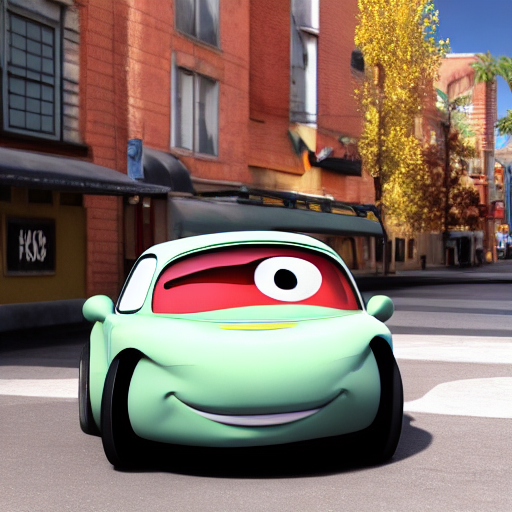

  1%|          | 1/120 [00:11<23:47, 12.00s/it]

  0%|          | 0/40 [00:00<?, ?it/s]


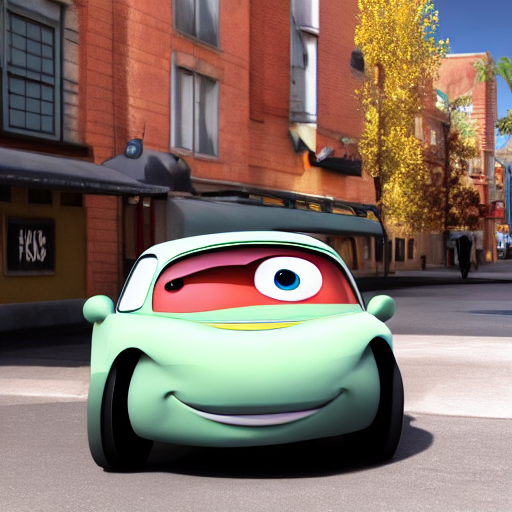

  2%|▏         | 2/120 [00:24<23:44, 12.07s/it]

  0%|          | 0/40 [00:00<?, ?it/s]


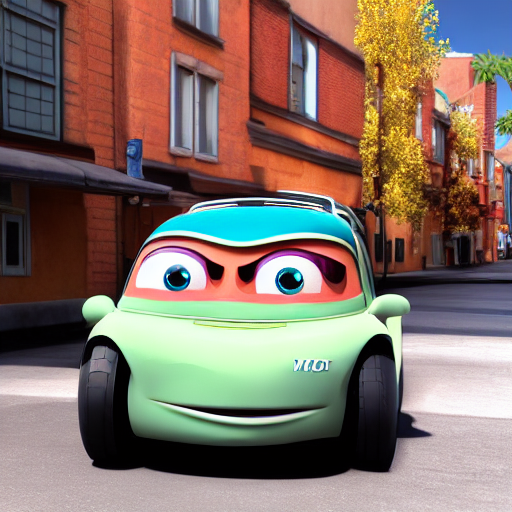

  2%|▎         | 3/120 [00:36<23:39, 12.13s/it]

  0%|          | 0/40 [00:00<?, ?it/s]


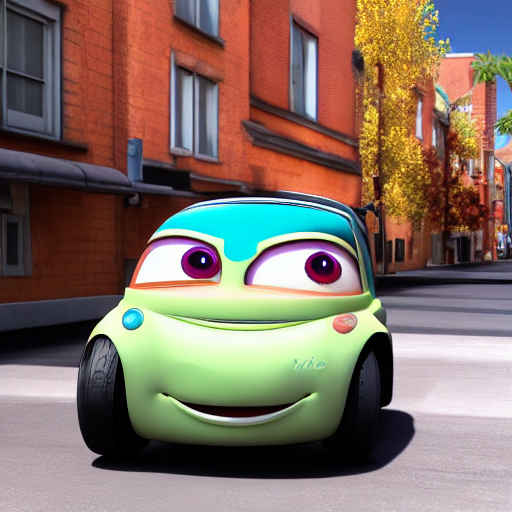

  3%|▎         | 4/120 [00:48<23:39, 12.24s/it]

  0%|          | 0/40 [00:00<?, ?it/s]


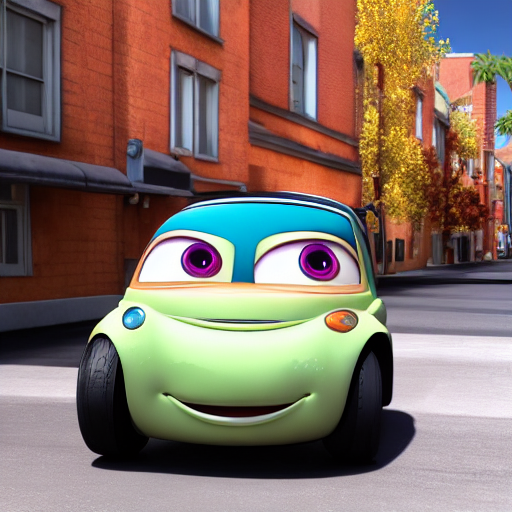

  4%|▍         | 5/120 [01:02<24:29, 12.77s/it]

  0%|          | 0/40 [00:00<?, ?it/s]


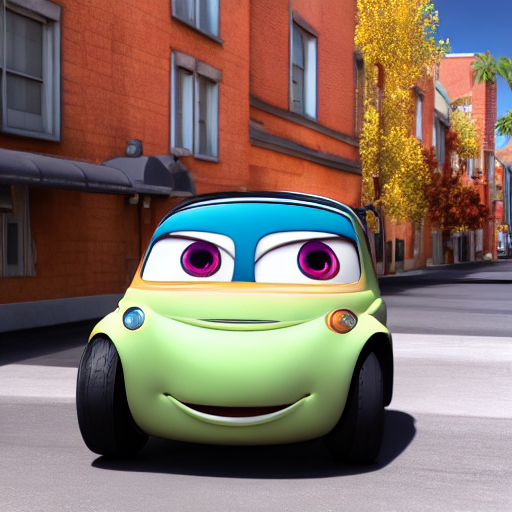

  5%|▌         | 6/120 [01:15<24:16, 12.78s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
from torch import autocast
from tqdm import tqdm
from transformers.models.clip.modeling_clip import CLIPTextModel
import os
if not os.path.exists(f'{config.output_path}/images'):
  os.makedirs(f'{config.output_path}/images')

rendered_frames = 0

def render_animation(config: AnimationConfig, pipe) -> int:
    global rendered_frames

    last_image = None
    # We can only feed the last image back in on _subsequent_ animation frames
    # So for the first frame, init_image must be available
    if config.init_image is not None:
      assert config.init_image.get_image(0, None) is not None

    positive_sentinel = 'positive'
    negative_sentinel = 'negative'


    positive_sentinel_token_ids = tokenize_to_ids(pipe, positive_sentinel)
    negative_sentinel_token_ids = tokenize_to_ids(pipe, negative_sentinel)
    empty_token_ids = tokenize_to_ids(pipe, "")

    with autocast("cuda"), torch.no_grad():
        for i in tqdm(range(config.total_frames)):

            # Interpolate text encodings
            class WrappedTextEncoder(CLIPTextModel):
              def __call__(self, token_ids, *args, **kwargs):
                if token_ids.equal(positive_sentinel_token_ids):
                  return (config.prompt_embeddings.get(i),)
                elif token_ids.equal(negative_sentinel_token_ids):
                  if config.negative_prompt_embeddings is not None:
                    return (config.negative_prompt_embeddings.get(i),)
                  else:
                    return pipe.orig_text_encoder(empty_token_ids)
                else:
                  raise Exception(token_ids, *args, **kwargs)
            pipe.text_encoder = WrappedTextEncoder(pipe.text_encoder.config)

            # Interpolate random latent noise for img2img
            def add_noise(
                original_samples: torch.FloatTensor,
                noise: torch.FloatTensor,
                timesteps: torch.IntTensor,
            ) -> torch.FloatTensor:
                new_noise = config.latent_noise.get(i)
    
                # We can pass in the full noise here, as orig_add_noise tempers it based on timesteps
                return pipe.scheduler.orig_add_noise(original_samples, new_noise, timesteps)
            pipe.scheduler.add_noise = add_noise

            if config.init_image is None:
                kwargs = {
                    # Interpolate random latent noise for txt2img
                    'latents': config.latent_noise.get(i),
                }
            else:
                # TODO: note that img2img must use the vae, and so samples randomly from the data
                # This means we get some randomness in img2img that is _not_ captured by our cached latent noise
                assert config.noising is not None
                kwargs = {
                    'init_image': config.init_image.get_image(i, last_image=last_image),
                    # Interpolate strengths (in case we are using img2img)
                    'strength': config.noising.get(i),
                }

            # This is for the typechecker
            callable_pipe: Callable = pipe
            images = callable_pipe(prompt=positive_sentinel,
                          guidance_scale=config.guidance_scale.get(i),
                          num_inference_steps=config.num_inference_steps.get(i),
                          height=config.height,
                          width=config.width,
                          negative_prompt=negative_sentinel,
                          **kwargs
                          ).images
            last_image = images[0]
            if rendered_frames < 10:
              media.show_images(images)
            images[0].save(f"{config.output_path}/images/output{i}.jpg")
            rendered_frames = i
    return config.total_frames

images_rendered = render_animation(config, pipe)

# Save and display animation

In [ ]:
# save all images into an animated gif
import imageio
images = []
for i in range(rendered_frames):
    images.append(imageio.imread(f"{config.output_path}/images/output{i}.jpg"))

def save_images_to_video(images, filename):
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  resampled_fps = config.fps * config.total_frames / config.init_image.movie_total_frames

  out = cv2.VideoWriter(filename, fourcc, resampled_fps, (images[0].shape[0], images[0].shape[1]))
  
  for i in range(len(images)):
      cv2_im = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)    
      out.write(cv2_im)
  out.release()
  return out

# video source
video_source = hasattr(config.init_image, 'video_path')

# save as mp4

# extract audio from original clip
import subprocess
if video_source:
  save_images_to_video(images, f'{config.output_path}/output-silent.mp4')
  subprocess.run(["ffmpeg",
                  "-i", config.init_image.video_path,
                  "-y", "-vn", "-acodec", "copy",
                  f"{config.output_path}/output-audio.aac"])
  subprocess.run(["ffmpeg",
                  "-i", f"{config.output_path}/output-silent.mp4",
                  "-i", f"{config.output_path}/output-audio.aac",
                  "-y", "-c:v", "copy", "-c:a", "aac",
                  f"{config.output_path}/output.mp4"])
else:
  save_images_to_video(images, f'{config.output_path}/output.mp4')

from google.colab import files
files.download(f'{config.output_path}/output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Display mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f'{config.output_path}/output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)